# Multivariate imputation with by chained equations (MICE)

In this notebook, we will use regression models like linear regression, k-nearest neighbors regression, random forests regression, or Bayesian regression, to estimate the value of the missing observations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Load data

In [2]:
# List with the variables to load:

variables = ["A2", "A3", "A8", "A11", "A14", "A15", "target"]

# Load only necessary variables:
data = pd.read_csv("credit_approval_uci.csv", usecols=variables)

data.head()

,A2,A3,A8,A11,A14,A15,target
0,30.83,0.000,1.25,1,202.0,0,1
1,58.67,4.460,3.04,6,43.0,560,1
2,24.50,NaN,NaN,0,280.0,824,1
3,27.83,1.540,3.75,5,100.0,3,1
4,20.17,5.625,1.71,0,120.0,0,1


## Split data into train and test sets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("target", axis=1),
    data["target"],
    test_size=0.3,
    random_state=0,
)

X_train.shape, X_test.shape

((483, 6), (207, 6))

In [4]:
# Find fraction of missing data:

X_train.isnull().mean()

A2     0.022774
A3     0.140787
A8     0.140787
A11    0.000000
A14    0.014493
A15    0.000000
dtype: float64

In [5]:
# Set up a MICE imputer using Bayes regression
# to estimate the missing data:

imputer = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=0,
)

In [6]:
# Train Bayes regression to estimate missing
# data in all variables:

imputer.fit(X_train)

IterativeImputer(estimator=BayesianRidge(), random_state=0)

In [7]:
# Replace missing values by the
# regression estimates:

X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [8]:
# The result is a NumPy array:

X_train

array([[4.608e+01, 3.000e+00, 2.375e+00, 8.000e+00, 3.960e+02, 4.159e+03],
       [1.592e+01, 2.875e+00, 8.500e-02, 0.000e+00, 1.200e+02, 0.000e+00],
       [3.633e+01, 2.125e+00, 8.500e-02, 1.000e+00, 5.000e+01, 1.187e+03],
       ...,
       [1.958e+01, 6.650e-01, 1.665e+00, 0.000e+00, 2.200e+02, 5.000e+00],
       [2.283e+01, 2.290e+00, 2.290e+00, 7.000e+00, 1.400e+02, 2.384e+03],
       [4.058e+01, 3.290e+00, 3.500e+00, 0.000e+00, 4.000e+02, 0.000e+00]])

In [9]:
# Corroborate that there is no missing data:

pd.DataFrame(X_train).isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

## Estimate missing data with different regression models

In [10]:
# Split data into train and test sets:

X_train, X_test, y_train, y_test = train_test_split(
    data.drop("target", axis=1),
    data["target"],
    test_size=0.3,
    random_state=0,
)

X_train.shape, X_test.shape

((483, 6), (207, 6))

In [11]:
# Set up multiple iterative imputer instances with
# different regression models:

imputer_bayes = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0)

imputer_knn = IterativeImputer(
    estimator=KNeighborsRegressor(n_neighbors=5), max_iter=10, random_state=0
)

imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(max_features="sqrt", random_state=0),
    max_iter=1000,
    random_state=0,
)

imputer_missForest = IterativeImputer(
    estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
    max_iter=1000,
    random_state=0,
)

In [12]:
# Fit the imputers:

imputer_bayes.fit(X_train)
imputer_knn.fit(X_train)
imputer_nonLin.fit(X_train)
imputer_missForest.fit(X_train)

IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
                 max_iter=1000, random_state=0)

In [13]:
# Replace missing data by the regression estimates:

X_test_bayes = imputer_bayes.transform(X_test)
X_test_knn = imputer_knn.transform(X_test)
X_test_nonLin = imputer_nonLin.transform(X_test)
X_test_missForest = imputer_missForest.transform(X_test)

In [14]:
# List with the name of the predictor variables:

predictors = [var for var in variables if var != "target"]

In [15]:
# Convert resulting NumPy array to dataframes:

X_test_bayes = pd.DataFrame(X_test_bayes, columns=predictors)
X_test_knn = pd.DataFrame(X_test_knn, columns=predictors)
X_test_nonLin = pd.DataFrame(X_test_nonLin, columns=predictors)
X_test_missForest = pd.DataFrame(X_test_missForest, columns=predictors)

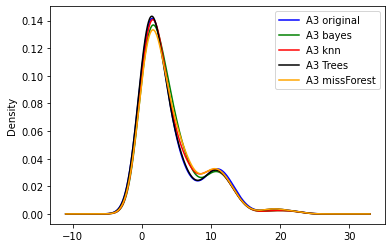

In [16]:
# Plot the original and imputed variable distributions:

fig = plt.figure()
ax = fig.add_subplot(111)

X_test["A3"].plot(kind="kde", ax=ax, color="blue")
X_test_bayes["A3"].plot(kind="kde", ax=ax, color="green")
X_test_knn["A3"].plot(kind="kde", ax=ax, color="red")
X_test_nonLin["A3"].plot(kind="kde", ax=ax, color="black")
X_test_missForest["A3"].plot(kind="kde", ax=ax, color="orange")

# add legends
lines, labels = ax.get_legend_handles_labels()
labels = ["A3 original", "A3 bayes", "A3 knn", "A3 Trees", "A3 missForest"]
ax.legend(lines, labels, loc="best")
plt.show()